# Sprint 12

# SimpleConv2d

## Setup

In [1]:
import numpy as np

In [2]:
class SimpleInitializer:
    """
    Simple initialization with Gaussian distribution
    Parameters
    ----------
    sigma : float
      Standard deviation of Gaussian distribution
    """
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, *shape):
        """
        Weight initialization
        Parameters
        ----------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in the later layer
        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(*shape)
        return W
    
    def B(self, *shape):
        """
        Bias initialization
        Parameters
        ----------
        n_nodes2 : int
          Number of nodes in the later layer
        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(*shape)
        return B

In [3]:
class HeInitializer:
    
    def W(self, n_nodes1, n_nodes2):
        self.sigma = np.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

In [4]:
class SimpleInitializerConv2d:
    
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, F, C, FH, FW):
        return self.sigma * np.random.randn(F, C, FH, FW)
    
    def B(self, F):
        return np.zeros(F)

In [5]:
class SGD:
    """
    Stochastic gradient descent
    Parameters
    ----------
    lr : Learning rate
    """
    
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        Update weights and biases for a layer
        Parameters
        ----------
        layer : Instance of the layer before update
        """
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return layer

In [6]:
class AdaGrad:
    
    def __init__(self, lr):
        self.lr = lr
        self.HW = 0.0
        self.HB = 0.0
        
    def update(self, layer):
        self.HW += layer.dW * layer.dW
        self.HB = layer.dB * layer.dB
        delta = 1e-7
        layer.W -= self.lr * layer.dW / (np.sqrt(self.HW) + delta)
        layer.B -= self.lr * layer.dB / (np.sqrt(self.HB) + delta)
        return layer

In [7]:
class ReLU:
    
    def forward(self, A):
        self.A = A
        Z = np.maximum(0, A)
        return Z
    
    def backward(self, dZ):
        dA = dZ * np.where(self.A > 0, 1, 0)
        return dA

In [8]:
class Softmax:
    
    def forward(self, A):
        self.Z = np.exp(A - np.max(A)) / np.sum(np.exp(A - np.max(A)), axis=1, keepdims=True)
        return self.Z
    
    def backward(self, dZ):
        return dZ

In [9]:
class GetMiniBatch:
    """
    Iterator to get a mini-batch
    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random number seed
    """
    
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        return self._stop
    
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [10]:
class FC:
    """
    Number of nodes Fully connected layer from n_nodes1 to n_nodes2
    Parameters
    ----------
    n_nodes1 : int
      Number of nodes in the previous layer
    n_nodes2 : int
      Number of nodes in the later layer
    initializer: instance of initialization method
    optimizer: instance of optimization method
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, activation):
        self.optimizer = optimizer
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.W = initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = initializer.B(self.n_nodes2)
        self.optimizer = optimizer
        self.activation = activation
        pass
    
    def forward(self, X):
        """
        forward
        Parameters
        ----------
        X : The following forms of ndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : The following forms of ndarray, shape (batch_size, n_nodes2)
            output
        """
        self.X = X
        self.A = np.dot(self.X, self.W) + self.B
        return self.activation.forward(self.A)
    
    def backward(self, dZ):
        """
        Backward
        Parameters
        ----------
        dA : The following forms of ndarray, shape (batch_size, n_nodes2)
            Gradient flowing from behind
        Returns
        ----------
        dZ : The following forms of ndarray, shape (batch_size, n_nodes1)
            Gradient to flow forward
        """
        dA = self.activation.backward(dZ)
        self.dB = np.sum(dA, axis=0)
        self.dW = np.dot(self.X.T, dA) / len(self.X)
        self.dZ = np.dot(dA, self.W.T)
        self = self.optimizer.update(self)
        return self.dZ

## Problem 1-3

In [11]:
class SimpleConv2d():
    """
    2D convolutional layer
    Parameters
    -------
    F: Number of output channels
    C: Number of input channels
    FH: Filter's height.
    FC: Filter's width.
    P: Padding.
    S: Stride.
    initializer: Instances of initialization methods
    optimizer: Instances of optimization methods
    """
    def __init__(self, F, C, FH, FW, P=0, S=1, initializer=None, optimizer=None, activation=None):
        # Create initializer
        if isinstance(initializer, tuple) and len(initializer) == 2:
            self.W = initializer[0]
            self.B = initializer[1]
        elif initializer is not None:
            self.initializer = initializer
            self.W = self.initializer.W(F, C, FH, FW)
            self.B = self.initializer.B(F)
        else:
            raise TypeError('Need an initializer')
        
        if not isinstance(S, int) or S < 1:
            raise ValueError('S must be an postive integer')
        if not isinstance(P, int) or P < 0:
            raise ValueError('P must be an non-negative integer')
        self.P = P
        self.S = S
        self.F = F
        self.C = C
        self.FH = FH
        self.FW = FW
        
        # Other setup
        self.optimizer = optimizer
        self.activation = activation
        
    def output_shape(self, H, W, P, FH, FW, S):
        OH = (H + 2*P - FH) / S + 1
        OW = (W + 2*P - FW) / S + 1
        return int(OH), int(OW)
    
    def forward(self, X):
        """
        Forward method.
        Parameters
        -------
        X: ndarray
            Input data
        Returns
        -------
        A: ndarray
            Output data
        """
        self.X = X
        self.N, C, self.H, self.WD = self.X.shape
        
        if C != self.C:
            raise ValueError(f'Incorrect shape of X, expected {self.C}, but got {C}')
            
        self.OH, self.OW = self.output_shape(self.H, self.WD, self.P, self.FH, self.FW, self.S)
        
        A = np.zeros([self.N, self.F, self.OH, self.OW])
        self.X_pad = np.pad(
            self.X,
            ((0,0), (0,0), (self.P, self.P), (self.P, self.P))
        )

        for n in range(self.N):
            for ch in range(self.F):
                for row in range(0, self.OH, self.S):
                    for col in range(0, self.OW, self.S):
                        A[n, ch, row, col] = np.sum(self.X_pad[n, :, row:row+self.FH, col:col+self.FW] \
                                             * self.W[ch, :, :, :]) + self.B[ch]
        if self.activation is None:
            return A
        return self.activation.forward(A)
    
    def backward(self, dZ):
        """
        Backward method.
        Parameters
        -------
        dZ: 
            The gradient flown in from behind.
        Returns
        -------
        dZ: ndarray
            Forward slope
        """
        if self.activation is None:
            dA = dZ
        else:
            dA = self.activation.backward(dZ)
        
        dZ = np.zeros(self.X_pad.shape)
        self.dW = np.zeros(self.W.shape)
        self.dB = np.zeros(self.B.shape)
        
        for n in range(self.N):
            for ch in range(self.F):
                for row in range(0, self.OH, self.S):
                    for col in range(0, self.OW, self.S):
                        dZ[n, :, row:row+self.FH, col:col+self.FW] += dA[n, ch, row, col] * self.W[ch, :, :, :]
                        
        dl_rows = range(self.P), range(self.H + self.P, self.H + 2*self.P, 1)
        dl_cols = range(self.P), range(self.WD + self.P, self.WD + 2*self.P, 1)
        
        dZ = np.delete(dZ, dl_rows, axis=2)
        dZ = np.delete(dZ, dl_cols, axis=3)
        
        for n in range(self.N):
            for ch in range(self.F):
                for row in range(self.OH):
                    for col in range(self.OW):
                        self.dW[ch, :, :, :] += dA[n, ch, row, col] * self.X_pad[n, :, row:row+self.FH, col:col+self.FW]
                        
        for ch in range(self.F):
            self.dB[ch] = np.sum(dA[:, ch, :, :])
        
        # Update
        if self.optimizer is not None:
            self = self.optimizer.update(self)
        
        return dZ

In [12]:
# (1,1,4,4)
x = np.array([[[[ 1,  2,  3,  4],
                [ 5,  6,  7,  8],
                [ 9, 10, 11, 12],
                [13, 14, 15, 16]]]])
# (2,1,3,3)
w = np.array([[[[ 0.,  0.,  0.],
               [ 0.,  1.,  0.],
               [ 0., -1.,  0.]]],
              [[[ 0.,  0.,  0.],
               [ 0., -1.,  1.],
               [ 0.,  0.,  0.]]]])

b = np.array([0, 0])

In [13]:
test1 = SimpleConv2d(2, 1, 3, 3, initializer=(w, b))
result = test1.forward(x)
result

array([[[[-4., -4.],
         [-4., -4.]],

        [[ 1.,  1.],
         [ 1.,  1.]]]])

In [14]:
dZ = np.array([[[[ -4,  -4],
                   [ 10,  11]],
                  [[  1,  -7],
                   [  1, -11]]]])

back_result = test1.backward(dZ)
back_result

array([[[[  0.,   0.,   0.,   0.],
         [  0.,  -5.,   4.,  -7.],
         [  0.,  13.,  27., -11.],
         [  0., -10., -11.,   0.]]]])

In [15]:
test2 = SimpleConv2d(4, 1, 3, 3, P=1, initializer=(np.ones([4, 1, 3, 3]), np.ones(4)))
result2 = test2.forward(np.ones([5, 1, 28, 28]))
result2.shape

(5, 4, 28, 28)

In [16]:
back_result2 = test2.backward(np.zeros([5, 4, 28, 28]))
back_result2.shape, test2.dW.shape, test2.dB.shape

((5, 1, 28, 28), (4, 1, 3, 3), (4,))

## [Problem 5] (Advance task) Creating average pooling

In [17]:
class MaxPool2D():
    
    def __init__(self, P):
        self.P = P
        self.PA = None
        self.Pidx = None
        
    def forward(self, A):
        N, F, OH, OW = A.shape
        PS = self.P
        PH, PW = int(OH/PS), int(OW/PS)
        
        self.params = N, F, OH, OW, PS, PH, PW
        
        # Pooling filter
        self.PA = np.zeros((N, F, PH, PW))
        self.Pidx = np.zeros((N, F, PH, PW))
        
        for n in range(N):
            for ch in range(F):
                for row in range(PH):
                    for col in range(PW):
                        self.PA[n, ch, row, col] = np.max(A[n, ch, row*PS:row*PS+PS, col*PS:col*PS+PS])
                        self.Pidx[n, ch, row, col] = np.argmax(A[n, ch, row*PS:row*PS+PS, col*PS:col*PS+PS])
        return self.PA
    
    def backward(self, dA):
        N, F, OH, OW, PS, PH, PW = self.params
        dP = np.zeros((N, F, OH, OW))
        
        for n in range(N):
            for ch in range(F):
                for row in range(PH):
                    for col in range(PW):
                        idx = self.Pidx[n, ch, row, col]
                        tmp = np.zeros((PS*PS))
                        for i in range(PS*PS):
                            if i == idx:
                                tmp[i] = dA[n, ch, row, col]
                            else:
                                tmp[i] = 0
                        dP[n, ch, row*PS:row*PS+PS, col*PS:col*PS+PS] = tmp.reshape(PS, PS)
        return dP

In [18]:
X = np.array([[[
    [3, 6, 0, 3, 1, 0],
    [6, 8, 3, 4, 1, 0],
    [7, 8, 6, 6, 8, 2],
    [7, 6, 4, 4, 0, 2],
    [0, 6, 6, 1, 5, 7],
    [0, 5, 5, 4, 7, 7]
]]])
X.shape

(1, 1, 6, 6)

In [19]:
pooling = MaxPool2D(P=2)
A = pooling.forward(X)

A

array([[[[8., 4., 1.],
         [8., 6., 8.],
         [6., 6., 7.]]]])

In [20]:
pooling.Pidx

array([[[[3., 3., 0.],
         [1., 0., 0.],
         [1., 0., 1.]]]])

In [21]:
dA = A

In [22]:
dZ = pooling.backward(dA)
dZ

array([[[[0., 0., 0., 0., 1., 0.],
         [0., 8., 0., 4., 0., 0.],
         [0., 8., 6., 0., 8., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 6., 6., 0., 0., 7.],
         [0., 0., 0., 0., 0., 0.]]]])

## [Problem 5] Create Average Pooling

In [23]:
class AveragePool2D():
    
    def __init__(self, P):
        self.P = P
        self.PA = None
        self.Pidx = None
        
    def forward(self, A):
        N, F, OH, OW = A.shape
        PS = self.P
        PH, PW = int(OH/PS), int(OW/PS)
        
        self.params = N, F, OH, OW, PS, PH, PW
        
        # Pooling filter
        self.PA = np.zeros((N, F, PH, PW))
        self.Pidx = np.zeros((N, F, PH, PW))
        
        for n in range(N):
            for ch in range(F):
                for row in range(PH):
                    for col in range(PW):
                        self.PA[n, ch, row, col] = np.mean(A[n, ch, row*PS:row*PS+PS, col*PS:col*PS+PS])
                        
        return self.PA
    
    def backward(self, dA):
        N, F, OH, OW, PS, PH, PW = self.params
        dP = np.zeros((N, F, OH, OW))
        
        for n in range(N):
            for ch in range(F):
                for row in range(PH):
                    for col in range(PW):
                        tmp = np.zeros((PS*PS))
                        for i in range(PS*PS):
                            tmp[i] = dA[n, ch, row, col] / (PS*PS)
                        dP[n, ch, row*PS:row*PS+PS, col*PS:col*PS+PS] = tmp.reshape(PS, PS)
        return dP

In [24]:
X = np.array([[[
    [2, 1, 2, 3, 0, 2],
    [4, 4, 8, 8, 8, 0],
    [5, 8, 0, 8, 7, 0],
    [8, 3, 0, 0, 0, 5],
    [0, 8, 3, 0, 5, 7],
    [4, 8, 3, 6, 7, 6]
]]])

In [25]:
pooling = AveragePool2D(P=2)
A = pooling.forward(X)
A

array([[[[2.75, 5.25, 2.5 ],
         [6.  , 2.  , 3.  ],
         [5.  , 3.  , 6.25]]]])

In [26]:
dA = np.array([[[
    [2, 6, 6],
    [6, 5, 3],
    [3, 6, 5]
]]])

In [27]:
dZ = pooling.backward(dA)
dZ

array([[[[0.5 , 0.5 , 1.5 , 1.5 , 1.5 , 1.5 ],
         [0.5 , 0.5 , 1.5 , 1.5 , 1.5 , 1.5 ],
         [1.5 , 1.5 , 1.25, 1.25, 0.75, 0.75],
         [1.5 , 1.5 , 1.25, 1.25, 0.75, 0.75],
         [0.75, 0.75, 1.5 , 1.5 , 1.25, 1.25],
         [0.75, 0.75, 1.5 , 1.5 , 1.25, 1.25]]]])

## [Problem 6] Flatten

In [28]:
class Flatten():
    
    def forward(self, X):
        self.shape = X.shape
        return X.reshape(len(X), -1)
    
    def backward(self, X):
        return X.reshape(self.shape)

In [29]:
X = np.zeros((10, 20, 30, 50))
flat = Flatten()
flat_forward = flat.forward(X)
flat_forward.shape

(10, 30000)

In [30]:
flat.backward(flat_forward).shape

(10, 20, 30, 50)

## [Problem 7] Learning and estimation

In [31]:
from sklearn.metrics import accuracy_score

class Scratch2dCNNClassifier():
    
    def __init__(self, NN, CNN, n_epoch=5, n_batch=1, verbose=False):
        self.NN = NN
        self.CNN = CNN
        self.n_epoch = n_epoch
        self.n_batch = n_batch
        self.verbose = verbose
        self.losses = []
        self.val_losses = []
        self.accs = []
        self.val_accs = []
        
    def loss_function(self, y, yt):
        delta = 1e-7
        return -np.mean(yt*np.log(y+delta))
    
    def accuracy(self, Z, Y):
        return accuracy_score(Y, Z)
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        Train a neural network classifier.
        
        Parameters:
        -------
        X: ndarray
            Training data.
        y: ndarray
            Target values of training data.
        X_val: ndarray
            Validation data.
        y_val: ndarray
            Target values of validation data.
        """
        for epoch in range(self.n_epoch):
            print(f"Epoch {epoch+1}")
            self.loss = 0
            self.val_loss = 0
            
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.n_batch)
            for mini_X_train, mini_y_train in get_mini_batch:
                
                # Forward
                forward_data = mini_X_train[:, np.newaxis, :, :]
                
                for layer in range(len(self.CNN)):
                    forward_data = self.CNN[layer].forward(forward_data)
                
                # Flatten
                fit = Flatten()
                forward_data = fit.forward(forward_data)
                
                # NN
                for layer in range(len(self.NN)):
                    forward_data = self.NN[layer].forward(forward_data)
                
                Z = forward_data
                
                # Backward
                backward_data = (Z - mini_y_train)/self.n_batch
                for layer in range(len(self.NN)-1, -1, -1):
                    backward_data = self.NN[layer].backward(backward_data)
                    
                backward_data = fit.backward(backward_data)
                
                for layer in range(len(self.CNN)-1, -1, -1):
                    backward_data = self.CNN[layer].backward(backward_data)
                
                self.loss += self.loss_function(Z, mini_y_train)
            
            loss = self.loss/len(get_mini_batch)
            acc = self.accuracy(self.predict(X), np.argmax(y, axis=1))
            print(f"loss: {loss}, acc: {acc}")
            self.losses.append(loss)
#             self.val_losses.append(self.val_loss/len(get_mini_batch))
            self.accs.append(acc)
#             if X_val is not None and y_val is not None:
#                 self.val_accs.append(self.accuracy(self.predict(X_val), np.argmax(y_val, axis=1)))
            
    def predict(self, X):
        pred_data = X[:, np.newaxis, :, :]
        
        for layer in range(len(self.CNN)):
            pred_data = self.CNN[layer].forward(pred_data)
            
        fit = Flatten()
        pred_data = fit.forward(pred_data)
        
        for layer in range(len(self.NN)):
            pred_data = self.NN[layer].forward(pred_data)
        
        return np.argmax(pred_data, axis=1)

In [32]:
NN = [
    FC(3136, 128, HeInitializer(), AdaGrad(0.01), ReLU()),
    FC(128, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax()),
]

In [33]:
CNN = [
    SimpleConv2d(F=32, C=1, FH=3, FW=3, P=1, S=1,
                 initializer=SimpleInitializerConv2d(),
                 optimizer=SGD(0.01),
                 activation=ReLU()),
    MaxPool2D(P=2),
    SimpleConv2d(F=64, C=32, FH=3, FW=3, P=1, S=1,
                 initializer=SimpleInitializerConv2d(),
                 optimizer=SGD(0.01),
                 activation=ReLU()),
    MaxPool2D(P=2),
]

In [34]:
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(48000, 28, 28)
(48000,)
(12000, 28, 28)
(12000,)


In [35]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis])

print(y_train_one_hot.shape)
print(y_val_one_hot.shape)

(48000, 10)
(12000, 10)


In [36]:
cnn1 = Scratch2dCNNClassifier(NN=NN, CNN=CNN, n_epoch=20, n_batch=20, verbose=False)

cnn1.fit(X_train[:200], y_train_one_hot[:200])

Epoch 1
loss: 0.22950013024572483, acc: 0.16
Epoch 2
loss: 0.2251226749303142, acc: 0.16
Epoch 3
loss: 0.215636658340688, acc: 0.16
Epoch 4
loss: 0.1954295979616378, acc: 0.37
Epoch 5
loss: 0.1580466495240975, acc: 0.64
Epoch 6
loss: 0.11698675633267004, acc: 0.77
Epoch 7
loss: 0.09042039109930419, acc: 0.785
Epoch 8
loss: 0.07553508714050092, acc: 0.815
Epoch 9
loss: 0.06400469326073029, acc: 0.85
Epoch 10
loss: 0.0553971352093953, acc: 0.87
Epoch 11
loss: 0.04835099728033258, acc: 0.885
Epoch 12
loss: 0.04266954635867636, acc: 0.895
Epoch 13
loss: 0.03812310199685194, acc: 0.905
Epoch 14
loss: 0.03416317354749439, acc: 0.91
Epoch 15
loss: 0.030720370398249448, acc: 0.91
Epoch 16
loss: 0.027783107208955347, acc: 0.93
Epoch 17
loss: 0.02542399153124229, acc: 0.94
Epoch 18
loss: 0.023230329343883645, acc: 0.945
Epoch 19
loss: 0.021341827995763327, acc: 0.945
Epoch 20
loss: 0.01953093716664969, acc: 0.945


In [41]:
y_train_pred = cnn1.predict(X_train[:200])
print(y_train_pred[:20])
print(classification_report(y_train[:200], y_train_pred))

[3 9 8 3 7 2 7 3 9 5 7 0 2 7 5 6 4 9 5 2]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        17
           2       1.00      0.91      0.95        32
           3       0.95      1.00      0.98        21
           4       0.88      0.82      0.85        17
           5       1.00      1.00      1.00        24
           6       0.95      1.00      0.97        18
           7       0.93      0.88      0.90        16
           8       0.95      1.00      0.98        20
           9       0.69      0.79      0.73        14

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.95      0.94      0.95       200



In [43]:
y_val_pred = cnn1.predict(X_val[:200])
print(y_val_pred[:20])
print(classification_report(y_val[:200], y_val_pred[:200]))

[1 0 9 4 7 9 3 9 7 7 8 9 1 5 5 1 3 7 3 9]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       0.95      0.78      0.86        23
           2       0.81      0.88      0.85        25
           3       0.78      0.90      0.84        20
           4       0.61      0.71      0.65        24
           5       0.63      0.80      0.71        15
           6       0.92      0.80      0.86        15
           7       0.84      0.84      0.84        19
           8       0.80      0.57      0.67        21
           9       0.55      0.55      0.55        20

    accuracy                           0.78       200
   macro avg       0.79      0.78      0.78       200
weighted avg       0.79      0.78      0.78       200



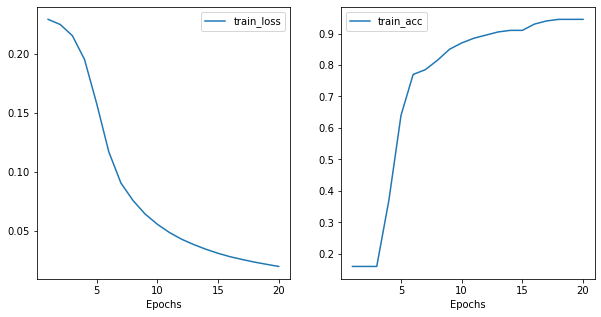

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(np.arange(1, cnn1.n_epoch+1), cnn1.losses, label='train_loss')
plt.legend()
plt.xlabel('Epochs')

plt.subplot(122)
plt.plot(np.arange(1, cnn1.n_epoch+1), cnn1.accs, label='train_acc')
plt.xlabel('Epochs')

plt.legend()
plt.show()

## [Problem 10] Calculation of output size and number of parameters

1.
- Input size : 144 x 144, 3 channels
- Filter size: 3 x 3, 6 channels
- Stride : 1
- Padding: none

OH = OW = (144 + 2 x 0 - 3) / 1 + 1 = 142

Output size: (6, 142, 142)

Parameters:
- Weight shape: (6, 3, 3, 3) => 162 parameters
- Bias shape: (6, ) => 6 parameters

Total: 168 parameters

2.
- Input size : 60x60, 24 channels
- Filter size: 3 x 3, 48 channels
- Stride : 1
- Padding: none

OH = OW = (60 + 2 x 0 - 3) / 1 + 1 = 58

Output size: (48, 58, 58)

Parameters:
- Weight shape: (48, 24, 3, 3) => 10368 parameters
- Bias shape: (48, ) => 48 parameters

Total: 10416 parameters

3.
- Input size : 20 x 20, 10 channels
- Filter size: 3 x 3, 20 channels
- Stride: 2
- Padding: none

OH = OW = (20 + 2 x 0 - 3) / 2 + 1 = 9.5

Output: (20, 9, 9)

Parameters:
- Weight shape: (20, 10, 3, 3) => 1800 parameters
- Bias shape: (20, ) => 20 parameters

Total: 1820 parameters